In [1]:
# 📌 1. Setup
# !pip install torch torchaudio einops

import os
import torch
import torchaudio
import numpy as np
import random
from einops import rearrange
from IPython.display import Audio, display

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# 📌 2. Load and preprocess 10-second WAV files from genre folder
GENRE = 'classical'  # 🔁 Change this to another folder like 'jazz'
DATA_PATH = f"data/genres_original/{GENRE}"
SAMPLE_RATE = 16000
DURATION = 10  # seconds
TARGET_LENGTH = SAMPLE_RATE * DURATION

mel_spec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_mels=128,
    power=2.0
).to(device)

def preprocess_waveform(file_path):
    waveform, sr = torchaudio.load(file_path)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

    # Crop or pad to 10 seconds
    if waveform.shape[1] > TARGET_LENGTH:
        waveform = waveform[:, :TARGET_LENGTH]
    else:
        waveform = torch.nn.functional.pad(waveform, (0, TARGET_LENGTH - waveform.shape[1]))

    waveform = waveform.to(device)
    spec = mel_spec_transform(waveform)
    return torch.log1p(spec)

file_paths = [os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) if f.endswith('.wav')]
random.shuffle(file_paths)

print(f"🎵 Loading {len(file_paths)} files from '{GENRE}'...")
X = torch.stack([preprocess_waveform(p) for p in file_paths[:50]])
X = X.squeeze(1)  # shape: [batch, mel_bins, time]
print(f"✅ Preprocessed input shape: {X.shape}")


🎵 Loading 100 files from 'classical'...
✅ Preprocessed input shape: torch.Size([50, 128, 313])


In [3]:
# 📌 3. Birdie-style State Space Model (Simplified)
class BirdieSSM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.A = torch.nn.Linear(hidden_size, hidden_size)
        self.B = torch.nn.Linear(input_size, hidden_size)
        self.C = torch.nn.Linear(hidden_size, input_size)
        self.h0 = torch.nn.Parameter(torch.randn(hidden_size))

    def forward(self, x):
        h = self.h0.unsqueeze(0).expand(x.size(0), -1)  # [batch, hidden]
        outputs = []
        for t in range(x.size(-1)):
            xt = x[:, :, t]
            h = self.A(h) + self.B(xt)
            yt = self.C(h)
            outputs.append(yt.unsqueeze(-1))
        return torch.cat(outputs, dim=-1)


In [15]:
# 📌 4. Train the model with default (reconstruction) objective
model = BirdieSSM(input_size=128, hidden_size=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

print("🎯 Training with default pretraining (reconstruction)...")
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output, X)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")


🎯 Training with default pretraining (reconstruction)...
Epoch 1 - Loss: 3.1685
Epoch 2 - Loss: 2.0918
Epoch 3 - Loss: 1.4851
Epoch 4 - Loss: 1.1815
Epoch 5 - Loss: 1.1298
Epoch 6 - Loss: 0.9705
Epoch 7 - Loss: 0.9297
Epoch 8 - Loss: 0.9383
Epoch 9 - Loss: 0.9253
Epoch 10 - Loss: 0.8918
Epoch 11 - Loss: 0.8569
Epoch 12 - Loss: 0.8283
Epoch 13 - Loss: 0.8001
Epoch 14 - Loss: 0.7697
Epoch 15 - Loss: 0.7417
Epoch 16 - Loss: 0.7193
Epoch 17 - Loss: 0.7006
Epoch 18 - Loss: 0.6828
Epoch 19 - Loss: 0.6655
Epoch 20 - Loss: 0.6488
Epoch 21 - Loss: 0.6327
Epoch 22 - Loss: 0.6165
Epoch 23 - Loss: 0.6002
Epoch 24 - Loss: 0.5846
Epoch 25 - Loss: 0.5696
Epoch 26 - Loss: 0.5543
Epoch 27 - Loss: 0.5390
Epoch 28 - Loss: 0.5245
Epoch 29 - Loss: 0.5111
Epoch 30 - Loss: 0.4986
Epoch 31 - Loss: 0.4868
Epoch 32 - Loss: 0.4755
Epoch 33 - Loss: 0.4642
Epoch 34 - Loss: 0.4532
Epoch 35 - Loss: 0.4430
Epoch 36 - Loss: 0.4331
Epoch 37 - Loss: 0.4232
Epoch 38 - Loss: 0.4135
Epoch 39 - Loss: 0.4041
Epoch 40 - Loss: 

In [16]:
# 📌 5. Define inverse transforms for mel → linear → waveform
mel_to_linear = torchaudio.transforms.InverseMelScale(
    n_stft=1025,       # ✅ 2048 FFT → 1025 frequency bins
    n_mels=128,
    sample_rate=SAMPLE_RATE,
).to(device)

griffin_lim = torchaudio.transforms.GriffinLim(
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    power=2.0,
    n_iter=32
).to(device)


In [17]:
# 📌 6. Generate & Save Music (Default Pretraining)
model.eval()
seed = X[0:1]  # take one sample
output = model(seed).detach()

mel_spec = torch.expm1(output[0].to(device))
linear_spec = mel_to_linear(mel_spec)
recon_waveform = griffin_lim(linear_spec)

torchaudio.save("birdie_generated.wav", recon_waveform.cpu().unsqueeze(0), SAMPLE_RATE)
print("✅ Saved: birdie_generated.wav")
display(Audio("birdie_generated.wav"))


✅ Saved: birdie_generated.wav


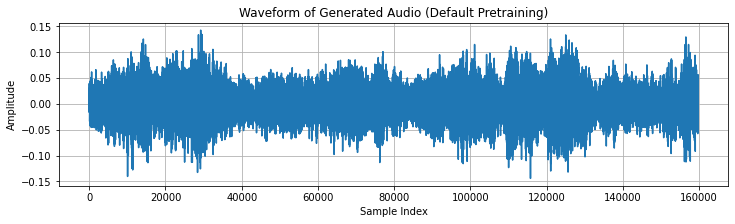

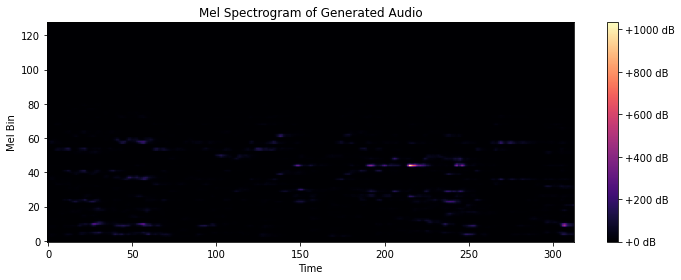

In [23]:
import matplotlib.pyplot as plt

# 🎧 Waveform Visualization
plt.figure(figsize=(12, 3))
plt.plot(recon_waveform.cpu().squeeze().numpy())
plt.title("Waveform of Generated Audio (Default Pretraining)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# 🎼 Mel Spectrogram Visualization
generated_mel = mel_spec.cpu().numpy()
plt.figure(figsize=(10, 4))
plt.imshow(generated_mel, origin="lower", aspect="auto", cmap="magma")
plt.title("Mel Spectrogram of Generated Audio")
plt.xlabel("Time")
plt.ylabel("Mel Bin")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

In [20]:
# 📌 7. Alternate Pretraining: Autoencoding
def corrupt_input(x, mask_ratio=0.3):
    corrupted = x.clone()
    time_steps = x.shape[-1]
    for i in range(x.size(0)):
        mask = torch.rand(time_steps) < mask_ratio
        corrupted[i, :, mask] = 0
    return corrupted

X_corrupt = corrupt_input(X)

print("🔁 Re-training with Autoencoding objective...")
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    output = model(X_corrupt)
    loss = loss_fn(output, X)
    loss.backward()
    optimizer.step()
    print(f"Autoencoding Epoch {epoch+1} - Loss: {loss.item():.4f}")


🔁 Re-training with Autoencoding objective...
Autoencoding Epoch 1 - Loss: 0.5744
Autoencoding Epoch 2 - Loss: 0.5301
Autoencoding Epoch 3 - Loss: 0.5082
Autoencoding Epoch 4 - Loss: 0.4635
Autoencoding Epoch 5 - Loss: 0.4822
Autoencoding Epoch 6 - Loss: 0.4494
Autoencoding Epoch 7 - Loss: 0.4383
Autoencoding Epoch 8 - Loss: 0.5217
Autoencoding Epoch 9 - Loss: 0.6342
Autoencoding Epoch 10 - Loss: 0.5868


In [21]:
# 📌 8. Save & Play Autoencoded Output
output_alt = model(seed).detach()

mel_spec_alt = torch.expm1(output_alt[0].to(device))
linear_spec_alt = mel_to_linear(mel_spec_alt)
recon_waveform_alt = griffin_lim(linear_spec_alt)

torchaudio.save("birdie_autoencoded.wav", recon_waveform_alt.cpu().unsqueeze(0), SAMPLE_RATE)
print("✅ Saved: birdie_autoencoded.wav")
display(Audio("birdie_autoencoded.wav"))


✅ Saved: birdie_autoencoded.wav


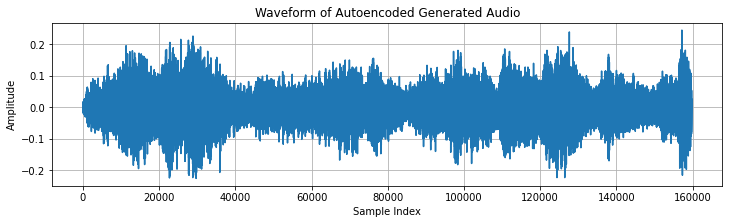

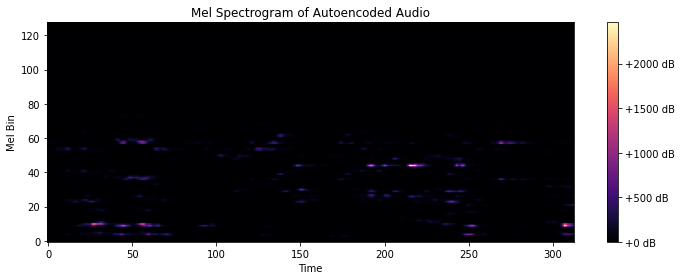

In [24]:
# 🎧 Waveform Visualization
plt.figure(figsize=(12, 3))
plt.plot(recon_waveform_alt.cpu().squeeze().numpy())
plt.title("Waveform of Autoencoded Generated Audio")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# 🎼 Mel Spectrogram Visualization
generated_mel_alt = mel_spec_alt.cpu().numpy()
plt.figure(figsize=(10, 4))
plt.imshow(generated_mel_alt, origin="lower", aspect="auto", cmap="magma")
plt.title("Mel Spectrogram of Autoencoded Audio")
plt.xlabel("Time")
plt.ylabel("Mel Bin")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

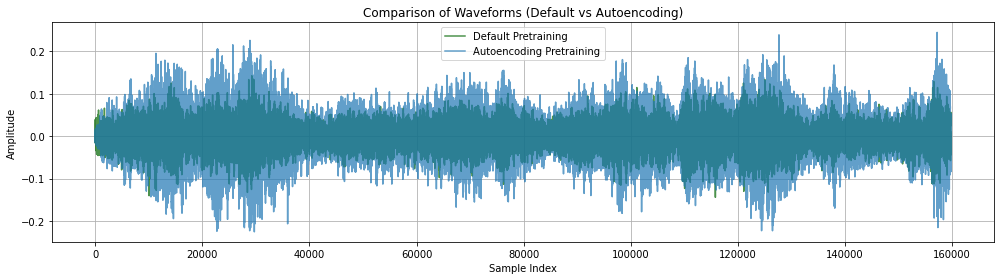

In [32]:
import matplotlib.pyplot as plt

# Convert tensors to numpy
waveform_default = recon_waveform.cpu().squeeze().numpy()
waveform_auto = recon_waveform_alt.cpu().squeeze().numpy()

# Ensure same length
min_len = min(len(waveform_default), len(waveform_auto))
waveform_default = waveform_default[:min_len]
waveform_auto = waveform_auto[:min_len]

# Plot
plt.figure(figsize=(14, 4))
plt.plot(waveform_default, label='Default Pretraining', color='darkgreen', alpha=0.7)
plt.plot(waveform_auto, label='Autoencoding Pretraining', alpha=0.7)
plt.title("Comparison of Waveforms (Default vs Autoencoding)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


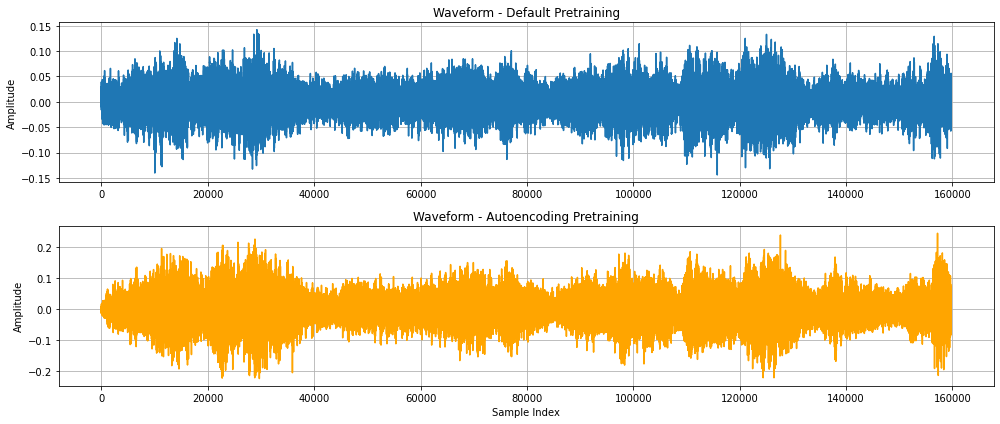

In [26]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(waveform_default)
plt.title("Waveform - Default Pretraining")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(waveform_auto, color='orange')
plt.title("Waveform - Autoencoding Pretraining")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()
